In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from tqdm.notebook import tqdm

import networkx as nx
import optimize as opt
import model as m
import graph_utils as gu

%matplotlib inline

In [32]:
all_nodes = gu.destinations_coords + gu.stations_coords
all_nodes = np.array(all_nodes)

# find minimum distance between nodes
min_dist = np.inf
for i in range(len(all_nodes)):
    for j in range(i+1, len(all_nodes)):
        dist = np.linalg.norm(all_nodes[i] - all_nodes[j])
        if dist < min_dist:
            min_dist = dist

print("Minimum distance between nodes: ", min_dist)
min_dist /= 2

# normalize distances by taking the minimum distance as 1 and setting the average position to 0
center = np.mean(all_nodes, axis=0)
destinations_coords = ((np.array(gu.destinations_coords) - center) / min_dist)
stations_coords = ((np.array(gu.stations_coords) - center) / min_dist)

all_nodes = np.vstack((destinations_coords, stations_coords))/0.8
lower_left = np.array([np.min(all_nodes[:,1]), np.min(all_nodes[:,0])])
upper_right = np.array([np.max(all_nodes[:,1]), np.max(all_nodes[:,0])])

destinations_coords = destinations_coords.tolist()
stations_coords = stations_coords.tolist()

lower_left, upper_right

Minimum distance between nodes:  0.00023430749027833662


(array([-69.79949909, -61.54015036]), array([82.77778283, 66.81682177]))

Average edge length (TOTAL): 54.88250462271687
Minimum edge length (TOTAL): 2.0000000000000004
Maximum edge length (TOTAL): 123.02501707699274


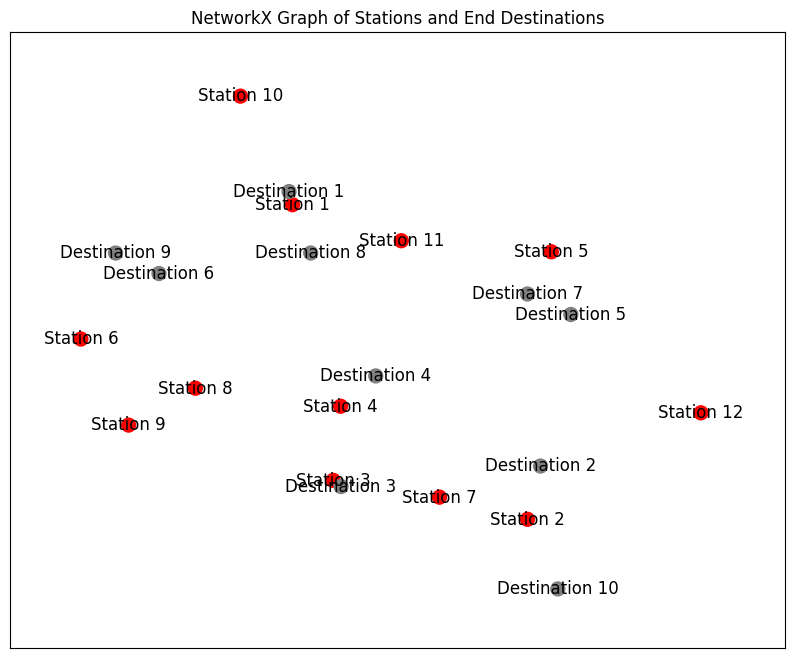

In [108]:
# Usage after creating the graph
G, station_nodes, end_destination_nodes = gu.create_graph_from_coordinates(stations_coords, destinations_coords)
average_edge_length = gu.calculate_average_edge_length(G)
min_edge_length = gu.calculate_minimum_edge_length(G)
max_edge_length = gu.calculate_maximum_edge_length(G)

print(f"Average edge length (TOTAL): {average_edge_length}")
print(f"Minimum edge length (TOTAL): {min_edge_length}")
print(f"Maximum edge length (TOTAL): {max_edge_length}")

# positions for all nodes
pos = [(p[1], p[0]) for p in stations_coords + destinations_coords]
pos = dict(zip(G.nodes, pos))

node_colors = ['red' if G.nodes[node]['type'] == 'station' else 'gray' for node in G.nodes]

# draw graph with map of Austin as background, but don't show the map
fig, ax = plt.subplots(figsize=(10, 8))
img = mpimg.imread('./resources/austin.PNG')
height, width, _ = img.shape
aspect = width / height

x, y = -13, -5
scale = 0.20

left, right = x - scale*width/2, x + scale*width/2
top, bottom = y + scale*height/2, y - scale*height/2

new_width = (right - left)
new_height = (top - bottom)
# ax.imshow(img, extent=[left, right, bottom, top], origin='upper')

nx.draw_networkx_nodes(G, pos, node_size=100, node_color=node_colors)
nx.draw_networkx_labels(G, pos)
plt.title("NetworkX Graph of Stations and End Destinations")
plt.xlim(lower_left[0], upper_right[0])
plt.ylim(lower_left[1], upper_right[1])
plt.show()

In [60]:
def fitness_from_coords(coordinate_list, agents, weights, seed=None, n_steps=1000):
    """
    Fitness function for the optimization problem, returns the negative of the average number of trips per agent

    Parameters:
    ---
    coordinate_list: dict
        Dictionary containing the coordinates of the stations and destinations
    agents: int
        Number of agents in the model
    weights: list
        List of weights for the destinations
    seed: int
        Random seed for the model
    n_steps: int
        Number of steps to run the model for

    Returns:
    ---
    float
        Negative of the average number of trips per agent
    """
    destinations = coordinate_list["destination"]
    stations = coordinate_list["station"]
    G, s, d = gu.create_graph_from_coordinates(stations + stations_coords, destinations)
    model = m.MyModel(agents, seed=seed, G=G, weights=weights)
    model.set_station_data(20, 10)
    for i in range(n_steps):
        model.step()
    return -1*model.trips_average()

def percent_error(x):
    return np.std(x)/np.mean(x)

def fitness(agents, weights, seed=None, n_steps=1000, trials=1):
    """
    Returns a lambda function that takes a list of coordinates and returns the fitness value. 
    Used as the fitness function for the optimizer class since it only accepts functions with 
    one parameter of destination coordinates

    Parameters:
    ---
    agents: int
        Number of agents in the model
    weights: list
        List of weights for the destinations
    seed: int
        Random seed for the model
    n_steps: int
        Number of steps to run the model for

    Returns:
    ---
    lambda
        Lambda function that takes a list of coordinates and returns the fitness value
    """
    return lambda x: np.mean([fitness_from_coords(x, agents, weights, seed, n_steps) for _ in range(trials)])

In [61]:
citymap = [(lower_left[0], lower_left[1]), (upper_right[0], upper_right[1])] + destinations_coords

In [74]:
results = []
for i in tqdm(range(1)):
    results.append(fitness(agents=200, weights=gu.ut_weights(), seed=None, n_steps=1500, trials=1)({"station": stations_coords, "destination": destinations_coords}))

  0%|          | 0/1 [00:00<?, ?it/s]

In [76]:
np.mean(results), np.std(results)

(-11.985, 0.0)

In [78]:
fitness_from_coords({"station": stations_coords + [(0, 0)], "destination": destinations_coords}, agents=200, weights=gu.ut_weights(), seed=None, n_steps=1500)

-12.09

In [84]:
# compute fitness throughout this rectangular region (array([-69.79949909, -61.54015036]), array([82.77778283, 66.81682177]))
x = np.linspace(-69.799, 82.778, 20)
y = np.linspace(-61.540, 66.817, np.ceil((66.817 + 61.540)/(82.778 + 69.799)*20).astype(int))

print(20*np.ceil((66.817 + 61.540)/(82.778 + 69.799)*30).astype(int))

X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)
for i in tqdm(range(len(x))):
    for j in tqdm(range(len(y))):
        Z[i, j] = np.mean([fitness_from_coords({"station": stations_coords + [(x[i], y[j])], "destination": destinations_coords}, agents=200, weights=gu.ut_weights(), seed=None, n_steps=1500) for _ in range(3)])

Z.dump("fitness_map.npy")

520


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

IndexError: index 17 is out of bounds for axis 0 with size 17

In [123]:
x = np.linspace(-69.799, 82.778, 20)
y = np.linspace(-61.540, 66.817, np.ceil((66.817 + 61.540)/(82.778 + 69.799)*20).astype(int))

In [ ]:
for i in tqdm(range(17, x.shape[0])):
    for j in tqdm(range(y.shape[0])):
        # print(f"({x[i]}, {y[j]}): {Z[j, i]}")
        Z[j, i] = np.mean([fitness_from_coords({"station": stations_coords + [(x[i], y[j])], "destination": destinations_coords}, agents=200, weights=gu.ut_weights(), seed=None, n_steps=1500) for _ in range(3)])

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

<Axes: >

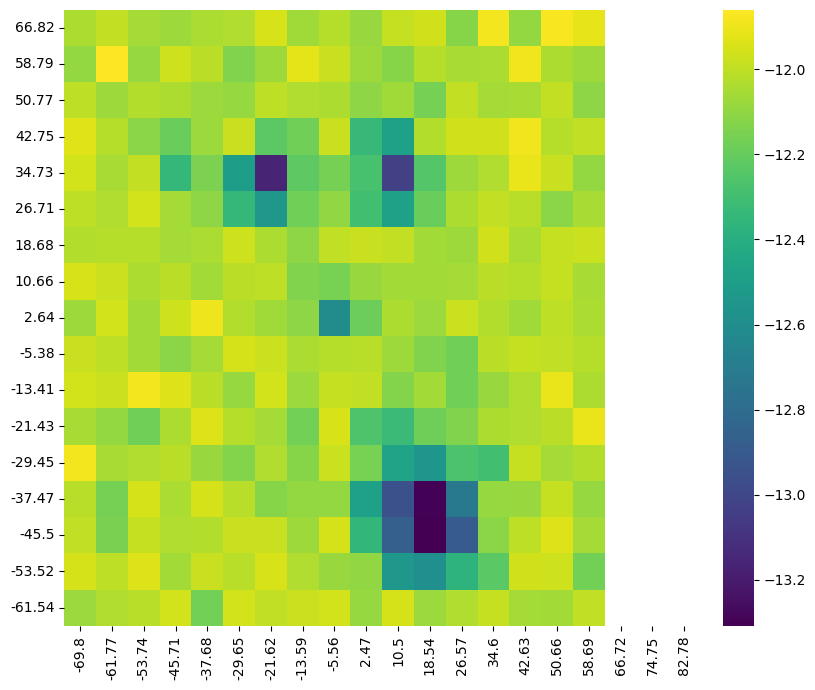

In [124]:
# display Z as a heatmap, flip the y-axis so that the origin is at the bottom left
# round the values to 2 decimal places
xticksvals = np.round(x, 2)
yticksvals = np.round(y, 2)
xticks = [str(i) for i in xticksvals]
yticks = [str(i) for i in yticksvals]
plt.figure(figsize=(10, 8))
sns.heatmap(Z[::-1,:17], xticklabels=xticks, yticklabels=yticks[::-1], cmap='viridis')